In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno

# regression models
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

# main classifier
from sklearn.ensemble import RandomForestClassifier

# for imputing
from sklearn.experimental import enable_iterative_imputer  # NO Quality Assurance
from sklearn.impute import IterativeImputer, SimpleImputer

# cross validation (folding)
from sklearn.model_selection import cross_val_score

In [2]:
# load dataset
df = pd.read_csv("./diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
# For the next columns, we will replace their zero values by nan values.
missing_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for field in missing_columns:
    df[field].replace(0, np.nan, inplace=True)

In [4]:
# print columns with nan values
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

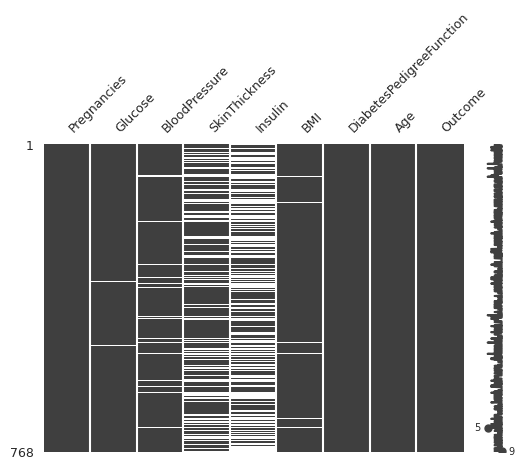

In [5]:
# Nulity matrix shows, by sample (from 1 to 768), the missing (nan) values in each column.
mno.matrix(df, figsize=(6, 4), fontsize=9)
plt.xticks(fontsize="9")
plt.yticks(fontsize="9")
plt.show()

We can observe from the diagram that the columns with more nan values are Insulin and SkinThickness.

In [6]:
# split out X and y datasets
X = df.drop(columns=['Outcome'], axis=1)
y = df[['Outcome']]

In [7]:
# The next classifier is fixed for each estimation of the metric (accuracy).
classifier = RandomForestClassifier(n_jobs=-1)

In [8]:
# Here, we calculate the average accuracy when imputing using simple strategies
score_simple_imputer = pd.DataFrame()

for strategy in ["mean", "median", "most_frequent"]:
    estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy=strategy), classifier)
    score_simple_imputer[strategy] = cross_val_score(estimator=estimator, X=X, y=y.values.ravel(),
                                                     scoring="accuracy", cv=5, n_jobs=-1)

In [9]:
# score for each fold.
score_simple_imputer

,mean,median,most_frequent
0,0.753247,0.753247,0.753247
1,0.733766,0.733766,0.707792
2,0.759740,0.753247,0.753247
3,0.816993,0.816993,0.810458
4,0.758170,0.758170,0.725490


In [10]:
# print the average accuracy of folds
score_simple_imputer.mean()

mean             0.764383
median           0.763085
most_frequent    0.750047
dtype: float64

In [11]:
# define the regression models for the iterative imputing processes.
estimators = [LinearRegression(),
              BayesianRidge(),
              KNeighborsRegressor(n_neighbors=16),
              RandomForestRegressor(
              # We tuned the hyperparameters of the RandomForestRegressor to get a good
              # enough predictive performance for a restricted execution time.
              n_estimators=100,
              max_depth=10,
              bootstrap=True,
              n_jobs=-1,
              random_state=0,
              ),
]
# tolerance values for each regression model
tolerances=(1e-3, 1e-3, 1e-1, 1e-1)

iterative imputer is sensible to the tolerance and dependent on the estimator used internally.
We tuned the tolerance to keep this example run with limited computational resources while not
changing the results too much compared to keeping the stricter default value for the tolerance parameter.

In [12]:
score_iterative_imputer = pd.DataFrame()

for estimator, tol in zip(estimators, tolerances):

    impute_estimator = make_pipeline(IterativeImputer(random_state=0, estimator=estimator, tol=tol, max_iter=25),
                                     classifier)

    name_estimator = estimator.__class__.__name__
    score_iterative_imputer[name_estimator] = cross_val_score(estimator=impute_estimator, X=X, y=y.values.ravel(),
                                                              scoring="accuracy", cv=5, n_jobs=-1)

In [13]:
# we concat scores for both imputing approaches
scores = pd.concat([score_simple_imputer, score_iterative_imputer],
                    keys=["SimpleImputer", "IterativeImputer"], axis=1)

In [14]:
scores.mean()

SimpleImputer     mean                     0.764383
                  median                   0.763085
                  most_frequent            0.750047
IterativeImputer  LinearRegression         0.751328
                  BayesianRidge            0.766981
                  KNeighborsRegressor      0.747432
                  RandomForestRegressor    0.752627
dtype: float64

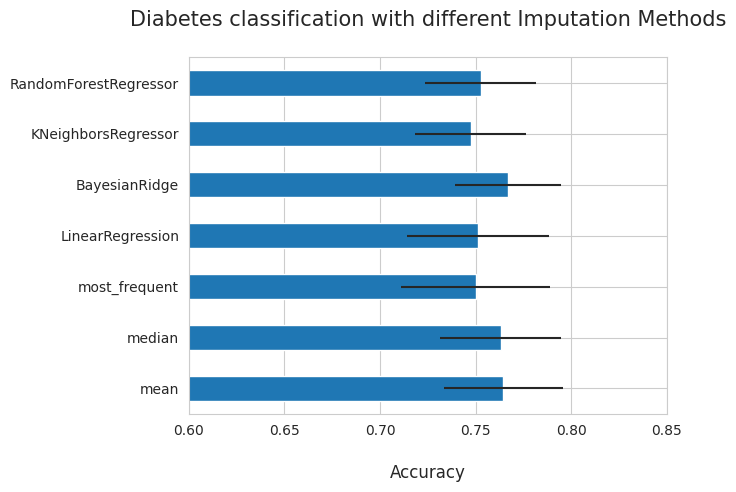

In [15]:
# plot california housing results
fig, ax = plt.subplots(figsize=(7, 5))

means = scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)

ax.set_title("Diabetes classification with different Imputation Methods\n", fontsize=15)
ax.set_xlabel("\nAccuracy", fontsize=12)
ax.set_yticklabels([label[1] for label in means.index.tolist()])
plt.xlim(0.6, 0.85)
plt.tight_layout(pad=1)
plt.show()

The iterative model BayesianRidge shows the highest averaged accuracy, followed by the simple imputing mean and median.
For this example, we evaluate the metric accuracy for a classification task, but imputation also can be carried out for regression tasks.
However, the iterative imputing models must be always regression models.